In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [2]:
# Configure the device gpu is required for faster 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
IMG_SIZE = 512

In [52]:
def imshow(tensor, title):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    if title is not None:
        plt.title(title)
    plt.imshow(image)
    plt.show()

In [49]:
def load_img(filename):
    preprocess_t = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()])
    image = Image.open(filename)
    image = preprocess_t(image).unsqueeze(0)
    return image.to(device, torch.float)

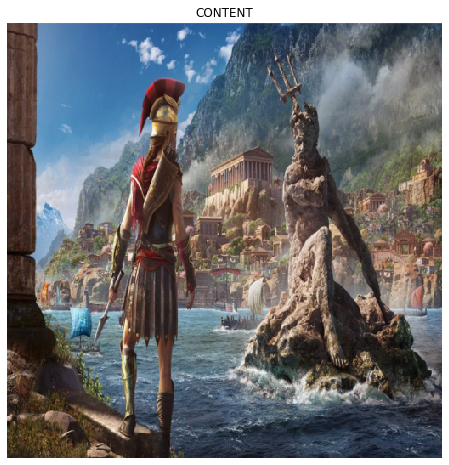

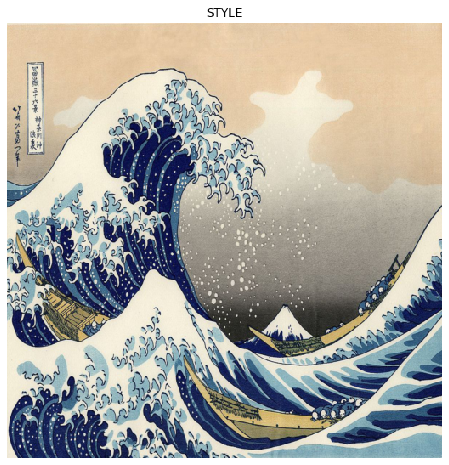

In [58]:
content_img = load_img("./data/images/content2.jpg")
style_img = load_img("./data/images/style.jpg")

plt.figure(figsize = (8, 8))
plt.axis("off")
imshow(content_img, title = "CONTENT")

plt.figure(figsize = (8, 8))
plt.axis("off")
imshow(style_img, title = "STYLE")

In [61]:
# lOAD THE MODEL FROM WHERE WE DERIVE ALL THE FEATURES
vgg19 = models.vgg19(pretrained=True)

# CHANGE POOLING
def pool_(model , pool = "avg"):
    if (pool == 'avg'):
        ct = 0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2,
                                         padding=0, ceil_mode=False)
                ct+=1
    elif (pool == "max"):
        ct = 0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2,
                                         padding=0, ceil_mode=False)
                ct+=1
    return model



model = copy.deepcopy(vgg19.features)
model.to(device)

for param in model.parameters():
    param.requires_grad = False